In [29]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.widgets import Slider
from train_model import ImageDataset
from test_model import VaeModel
%matplotlib widget

In [30]:
df = ImageDataset('img_align_celeba', split_size=0.01, batch_size=100)
train_df, _ = df.get_image_dataset()
model_2 = VaeModel(train_df)
vae_2 = model_2.load_vae_model(2)
model_3 = VaeModel(train_df, 200)
vae_3 = model_3.load_vae_model(3)

Found 3024 files belonging to 1 classes.
Using 2994 files for training.
Found 3024 files belonging to 1 classes.
Using 30 files for validation.


In [31]:
def generate_images(model, vae_model):
    """ Generates a plot for displaying the reconstructed image for set of
    latent variables captured from the slider on the plot.
    """
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(9, 2, figure=fig)
    ax_title = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1:-1, 1])
    ax2 = fig.add_subplot(gs[2, 0])
    ax3 = fig.add_subplot(gs[3, 0])
    ax4 = fig.add_subplot(gs[4, 0])
    ax5 = fig.add_subplot(gs[5, 0])
    ax6 = fig.add_subplot(gs[6, 0])
    ax7 = fig.add_subplot(gs[7, 0])
    ax8 = fig.add_subplot(gs[1, 0])
    ax9 = fig.add_subplot(gs[-1, 1])

    latent_space_min, latent_space_max = model.get_latent_space_min_max(vae_model)
    latent_space = tf.Variable([[random.uniform(min_value, max_value) for min_value, max_value in zip(latent_space_min, latent_space_max)]]).numpy()

    ax_title.text(0.5, 0.5, f'Random Face Generator using {latent_space.shape[1]} Latent Variables', ha='center', va='center', fontsize=14, fontweight='bold')
    ax8.text(0.5, 0.5, 'Latent Variables', ha='center', va='center')
    ax9.text(0.5, 0.5, 'Reconstructed Image', ha='center', va='center')
    print('Re-run the cell to load new image')

    latent_space_min, latent_space_max = model.get_latent_space_min_max(vae_model)
    predictions = vae_model.sample(tf.Variable(latent_space)) * 255.
    image = ax1.imshow(predictions[0].numpy().astype("uint8"))

    def update(val):
        """ Updates the decoder image after changes in latent variables
        done using sliders.
        """
        for i, slider in enumerate(freq_slider):
            latent_space[0][i] = slider.val
        predictions = vae_model.sample(tf.Variable(latent_space)) * 255.
        image.set_data(predictions[0].numpy().astype("uint8"))
        fig.canvas.draw_idle()

    freq_slider = []
    for index, ax in enumerate([ax2, ax3, ax4, ax5, ax6, ax7]):
        freq_slider.append(Slider(
            ax=fig.add_axes(ax).inset_axes([0, 0.35, 1, 0.3]),
            label=f'Dim {index + 1}',
            valmin=latent_space_min[index],
            valmax=latent_space_max[index],
            valinit=latent_space[0][index],
        ))

        freq_slider[index].on_changed(update)

    ax_title.axis('off')
    ax1.axis('off')
    ax2.axis('off') 
    ax3.axis('off')
    ax4.axis('off')
    ax5.axis('off')
    ax6.axis('off')
    ax7.axis('off')
    ax8.axis('off')
    ax9.axis('off')

    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95, left=0.1)

    plt.show()

Re-run the cell to load new image


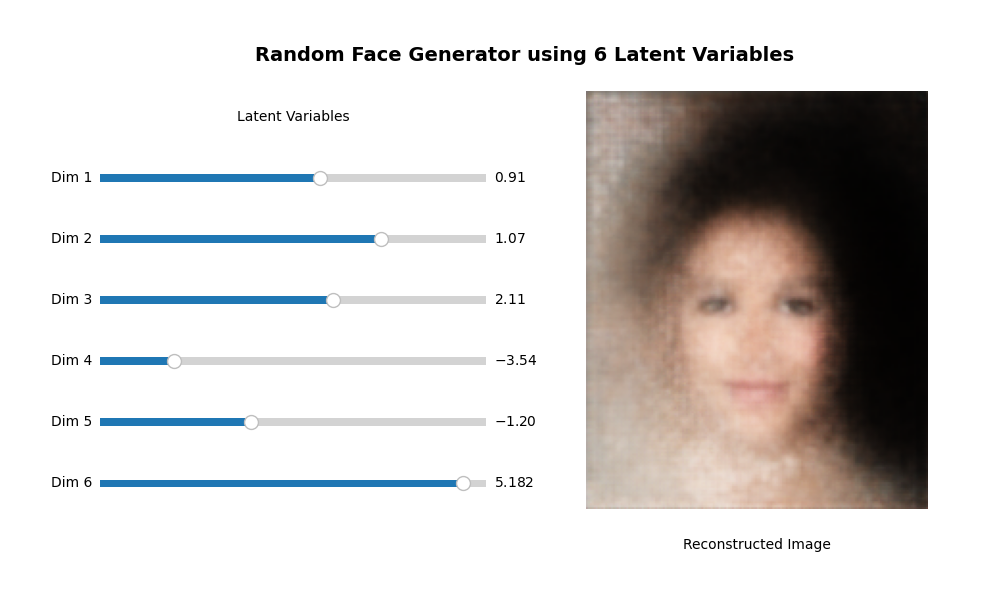

In [58]:
generate_images(model_2, vae_2)

Re-run the cell to load new image


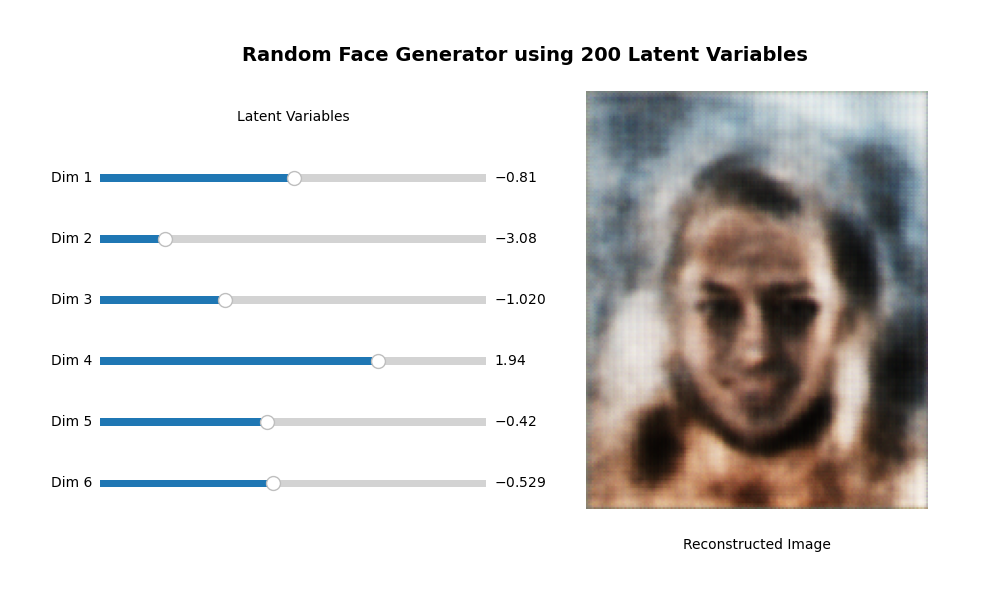

In [59]:
generate_images(model_3, vae_3)

In [42]:
def generate_images_from_masked_frame(model, vae_model):
    """ Generates a plot for displaying the image with the mask and 2 VAE
    model's decoder outputs for the masked image.
    """
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(10, 2, figure=fig, width_ratios=[5, 5])
    ax_title = fig.add_subplot(gs[0, :])
    ax0 = fig.add_subplot(gs[1:-1, 0])
    ax1 = fig.add_subplot(gs[1:-1, 1])
    ax2 = fig.add_subplot(gs[-1, 0])
    ax3 = fig.add_subplot(gs[-1, 1])

    ax_title.text(0.5, 0.5, 'Image Reconstruction', ha='center', va='center', fontsize=14, fontweight='bold')
    ax2.text(0.5, 0.5, 'Original Image', ha='center', va='center')
    print('Re-run the cell to load new image')

    decoder_images = []
    decoder_MSE_axis = [ax3]
    decoder_MSE_text = []
    decoder_images_axis = [ax1]

    model.original_image = model.get_original_image()
    for index, ax in enumerate(decoder_images_axis):
        masked_images, latent_space = model.get_latent_space(vae_model)
        predictions = vae_model.sample(tf.Variable(latent_space)) * 255.
        mse = model.calculate_MSE(masked_images, predictions)
        decoder_images.append(ax.imshow(predictions[0].numpy().astype("uint8")))
        decoder_MSE_text.append(decoder_MSE_axis[index].text(0.5, 0.5, f'MSE = {mse}', ha='center', va='center'))
    main_image = ax0.imshow(masked_images[0].numpy().astype("uint8"))

    def next(event):
        """ To load new image when the "Load new image" button is clicked.
        """
        model.original_image = model.get_original_image()
        for index, image in enumerate(decoder_images):
            masked_images, latent_space = model.get_latent_space(vae_model)
            predictions = model.vae_models[index].sample(tf.Variable(latent_space)) * 255.
            mse = model.calculate_MSE(masked_images, predictions)
            image.set_data(predictions[0].numpy().astype("uint8"))
            decoder_MSE_text[index].set_text(f'MSE = {mse}')
        main_image.set_data(masked_images[0].numpy().astype("uint8"))
        fig.canvas.draw_idle()

    ax_title.axis('off')
    ax0.axis('off')
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')

    fig.subplots_adjust(top=0.95, bottom=0.1, right=0.95, left=0.05)

    plt.show()

Re-run the cell to load new image


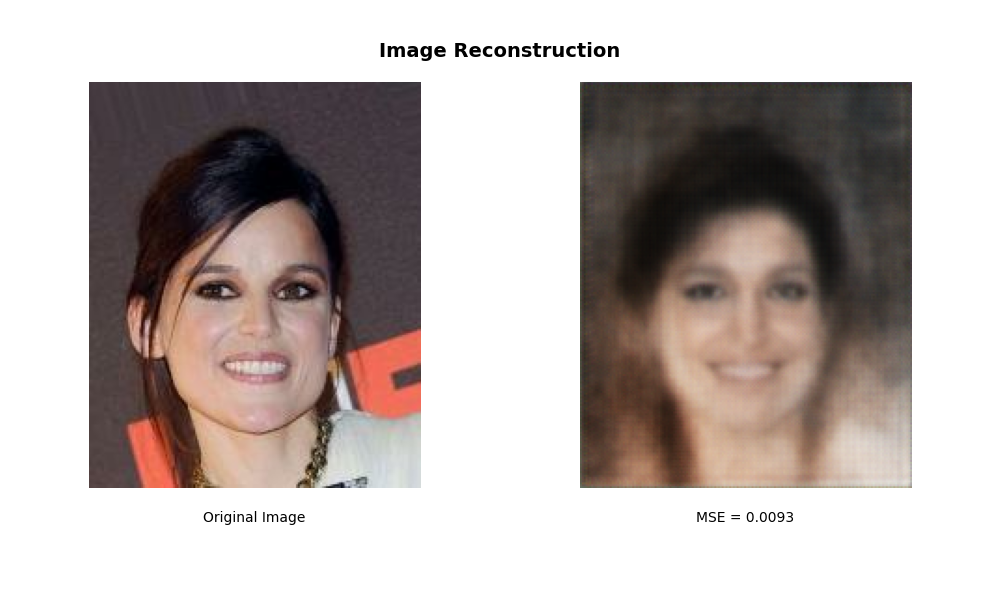

In [57]:
generate_images_from_masked_frame(model_3, vae_3)